In [394]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.constants import N_A
import math


In [395]:
Target_cell_number = 2e5
well_size = 150e-6
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
r_ab = 1.25e-8
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
reaction_volume1 = (2*math.pi*(r_ab**3))/3
reaction_volume2 = (2/3)*math.pi*((0.5*r_ab)**3)
reaction_volume3 = (2/3)*math.pi*((2*r_ab)**3)
reaction_volume_4 = (1/3)*math.pi*((r_ab)**3)

t_end = 60*60*1000
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]

#A00 initial assumed to be 0 because of size exclusion in synapse

In [396]:
def R_single_cell(t, z, Ainit, rtot, kon, k2, koff):
     
     k = kon/sigma
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0) - koff*z[0] - (k2*Ag*z[0]/rtot) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]/rtot) - 2*koff*z[1]

     return [dA10, dA11]

def S_single_cell(t, z, Ainit, rtot, kon, k2, koff):
     
     k = kon/sigma
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0) - koff*z[0] - (k2*Ag*z[0]) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]) - 2*koff*z[1]

     return [dA10, dA11]

In [397]:
def R_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot, rtot_fc, Atot):


    A0 = (Atot - (z[0] + z[1] + z[3] + z[4] + z[2]))
    rt = rtot- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc - z[2] - (z[3] + z[4])
    
    dA10 = 2*k1*(A0)*(rt) - k1off*z[0] - k2*z[0]*(rt/rtot) + 2*k1off*z[1] - k4*z[0]*(rf/rtot_fc) + k2off*z[3]
    dA20 = k2*z[0]*(rt/rtot) - 2*k1off*z[1] - k5*z[1]*(rf/rtot_fc) + k2off*z[4]
    dA01 = k3*(A0)*(rf) - k2off*z[2] - 2*k6*z[2]*(rt/rtot) + k1off*z[3]
    dA11 = k4*z[0]*(rf/rtot_fc) - k2off*z[3] + 2*k6*z[2]*(rt/rtot) -k1off*z[3] - k7*z[3]*(rt/rtot) + 2*k1off*z[4]
    dA21 = k5*z[1]*(rf/rtot_fc) - k2off*z[4] + k7*z[3]*(rt/rtot) - 2*k2off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

def S_two_cells(t, z, k1, k2, k3, k4, k1off, k2off, rtot, rtot_fc, Atot):


    A0 = (Atot - (z[0] + z[1] + z[3] + z[4] + z[2]))
    rt = rtot- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc - z[2] - (z[3] + z[4])
    
    dA10 = 2*k1*(A0)*(rt) - k1off*z[0] - k2*z[0]*(rt) + 2*k1off*z[1] - k4*z[0]*(rf) + k2off*z[3]
    dA20 = k2*z[0]*(rt) - 2*k1off*z[1] - k4*z[1]*(rf) + k2off*z[4]
    dA01 = k3*(A0)*(rf) - k2off*z[2] - 2*k2*z[2]*(rt) + k1off*z[3]
    dA11 = k4*z[0]*(rf) - k2off*z[3] + 2*k2*z[2]*(rt) -k1off*z[3] - k2*z[3]*(rt) + 2*k1off*z[4]
    dA21 = k4*z[1]*(rf) - k2off*z[4] + k2*z[3]*(rt) - 2*k2off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [398]:
kon = 1e5
qon = 6.5e3
koff = 1e-4
qoff = 4.7e-3
rtot = 1e5
rtot_fc = 2.2e5
rtot_synapse = rtot*tumour_cell_IS_proportion
rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion

k1 = kon/sigma_synapse
k3 = qon/sigma_synapse

target_effective_conc1 =(rtot_synapse)*(synapse_width**2)*(1/N_A)/(reaction_volume1)
k2 = target_effective_conc1*kon

target_effective_conc2 = (rtot_fc_synapse)*(synapse_width)*(1/N_A)/(reaction_volume3)
k4 = target_effective_conc2*qon

target_effective_conc3 = (rtot_fc_synapse)*(synapse_width)*(1/N_A)/(reaction_volume1)
k5 = target_effective_conc3*qon

target_effective_conc4 = (rtot_synapse)*(synapse_width)*(1/N_A)/(reaction_volume3)
k6 = target_effective_conc2*kon

target_effective_conc5 = (rtot_synapse)*(synapse_width)*(1/N_A)/(reaction_volume_4)
k7 = target_effective_conc5*kon


2.214052089565129e-10 3.264752649189157e-05


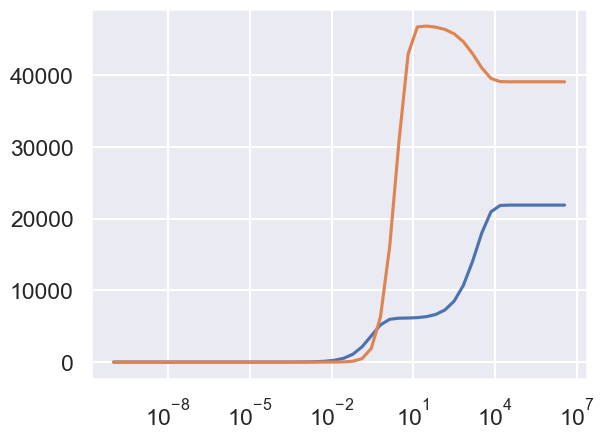

In [399]:
Ainit = 1e-6
target_effective_conc =(rtot)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume1)

k2_single = target_effective_conc*kon
z0 = [0, 0]
print(kon/sigma, k2_single/rtot)
z = solve_ivp(R_single_cell, tspan, z0, method='Radau', t_eval=t, args=(Ainit, rtot, kon, k2_single, koff))

A1 = z.y[0]
A2 = z.y[1]

plt.plot(t, A1, label = r'$A_{10}$')
plt.plot(t, A2, label = r'$A_{20}$')
plt.xscale('log')
A10_IC = A1[-1]*tumour_cell_IS_proportion
A20_IC = A2[-1]*tumour_cell_IS_proportion
Atot = A10_IC + A20_IC
z0 = [A10_IC, A20_IC, 0, 0, 0]
z = solve_ivp(R_two_cells, tspan, z0, method='Radau', t_eval=t, args=(k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot))

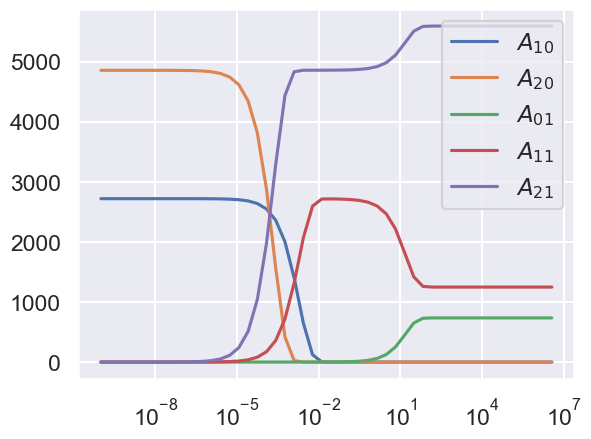

In [400]:
sns.set_theme()
sns.set_context('talk')

A10 = z.y[0]
A20 = z.y[1]
A01 = z.y[2]
A11 = z.y[3]
A21 = z.y[4]

plt.plot(t, A10, label = r'$A_{10}$')
plt.plot(t, A20, label = r'$A_{20}$')
plt.plot(t, A01, label = r'$A_{01}$')
plt.plot(t, A11, label = r'$A_{11}$')
plt.plot(t, A21, label = r'$A_{21}$')


plt.xscale('log')
plt.legend(loc='best')
plt.show()

In [401]:
A0s = np.geomspace(1e-12, 1e-4, 50)
A10s = np.zeros_like(A0s)
A20s = np.zeros_like(A0s)
A01s = np.zeros_like(A0s)
A11s = np.zeros_like(A0s)
A21s = np.zeros_like(A0s)

for i, Ainit in enumerate(A0s):
    
    z0 = [0, 0]
    z = solve_ivp(R_single_cell, tspan, z0, method='Radau', t_eval=t, args=(Ainit, rtot, kon, k2_single, koff))

    A1 = z.y[0]
    A2 = z.y[1]

    A10_IC = A1[-1]*tumour_cell_IS_proportion
    A20_IC = A2[-1]*tumour_cell_IS_proportion
    Atot = A10_IC + A20_IC
    z0 = [A10_IC, A20_IC, 0, 0, 0]
    z = solve_ivp(R_two_cells, tspan, z0, method='Radau', t_eval=t, args=(k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot))

    A10 = z.y[0]
    A20 = z.y[1]
    A01 = z.y[2]
    A11 = z.y[3]
    A21 = z.y[4]

    A10s[i] = A10[-1]
    A20s[i] = A20[-1]
    A01s[i] = A01[-1]
    A11s[i] = A11[-1]
    A21s[i] = A21[-1]

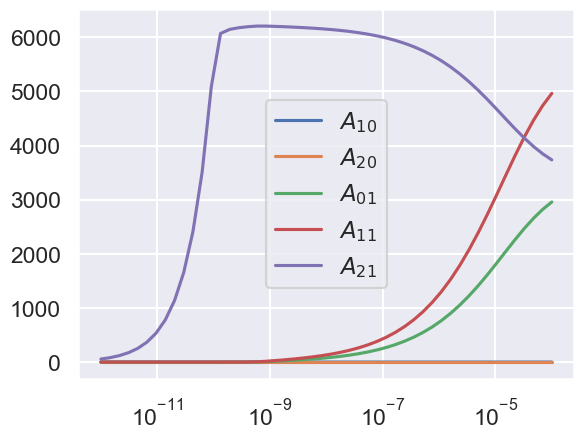

In [402]:
plt.plot(A0s, A10s, label = r'$A_{10}$')
plt.plot(A0s, A20s, label = r'$A_{20}$')
plt.plot(A0s, A01s, label = r'$A_{01}$')
plt.plot(A0s, A11s, label = r'$A_{11}$')
plt.plot(A0s, A21s, label = r'$A_{21}$')


plt.xscale('log')
plt.legend(loc='best')
plt.show()

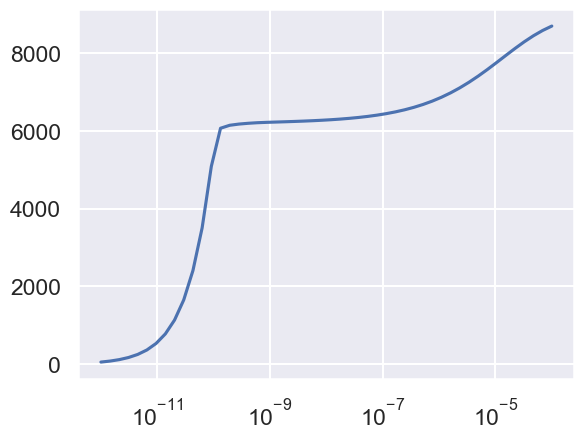

In [403]:
plt.plot(A0s, A11s + A21s)
plt.xscale('log')

2.214052089565129e-10 0.00024867959858108647


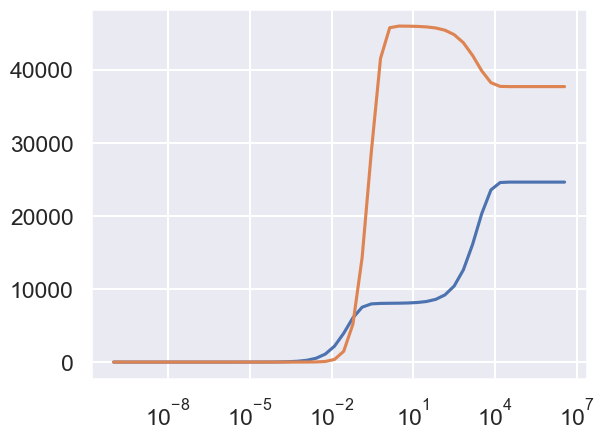

In [404]:
D_t = 5e-14
D_f = 7.4e-14

kon=1e5
k1 = kon/sigma_synapse
k3 = qon/sigma_synapse
k2 = 4*D_t/tumour_cell_surface_area
k4 = 4*D_f/NK_cell_surface_area
print(kon/sigma, k2)
Ainit = 1e-5

z0 = [0, 0]
z = solve_ivp(S_single_cell, tspan, z0, method='Radau', t_eval=t, args=(Ainit, rtot, kon, k2, koff))

A1 = z.y[0]
A2 = z.y[1]

plt.plot(t, A1, label = r'$A_{10}$')
plt.plot(t, A2, label = r'$A_{20}$')
plt.xscale('log')
A10_IC = A1[-1]*tumour_cell_IS_proportion
A20_IC = A2[-1]*tumour_cell_IS_proportion
Atot = A10_IC + A20_IC
z0 = [A10_IC, A20_IC, 0, 0, 0]
z = solve_ivp(S_two_cells, tspan, z0, method='Radau', t_eval=t, args=(k1, k2, k3, k4, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot))

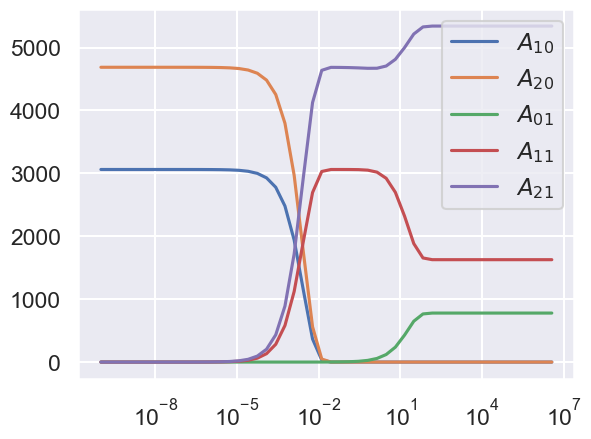

In [405]:
A10 = z.y[0]
A20 = z.y[1]
A01 = z.y[2]
A11 = z.y[3]
A21 = z.y[4]

plt.plot(t, A10, label = r'$A_{10}$')
plt.plot(t, A20, label = r'$A_{20}$')
plt.plot(t, A01, label = r'$A_{01}$')
plt.plot(t, A11, label = r'$A_{11}$')
plt.plot(t, A21, label = r'$A_{21}$')


plt.xscale('log')
plt.legend(loc='best')
plt.show()

In [406]:
A0s = np.geomspace(1e-12, 1e-4, 50)
A10s = np.zeros_like(A0s)
A20s = np.zeros_like(A0s)
A01s = np.zeros_like(A0s)
A11s = np.zeros_like(A0s)
A21s = np.zeros_like(A0s)

for i, Ainit in enumerate(A0s):
    print(i)
    z0 = [0, 0]
    z = solve_ivp(S_single_cell, tspan, z0, method='Radau', t_eval=t, args=(Ainit, rtot, kon, k2, koff))

    A1 = z.y[0]
    A2 = z.y[1]

    A10_IC = A1[-1]*tumour_cell_IS_proportion
    A20_IC = A2[-1]*tumour_cell_IS_proportion
    Atot = A10_IC + A20_IC
    z0 = [A10_IC, A20_IC, 0, 0, 0]
    z = solve_ivp(S_two_cells, tspan, z0, method='Radau', t_eval=t, args=(k1, k2, k3, k4, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot))

    A10 = z.y[0]
    A20 = z.y[1]
    A01 = z.y[2]
    A11 = z.y[3]
    A21 = z.y[4]

    A10s[i] = A10[-1]
    A20s[i] = A20[-1]
    A01s[i] = A01[-1]
    A11s[i] = A11[-1]
    A21s[i] = A21[-1]

0
1
2
3
4
5
6
7
8
9
10
11


KeyboardInterrupt: 

In [ ]:
plt.plot(A0s, A10s, label = r'$A_{10}$')
plt.plot(A0s, A20s, label = r'$A_{20}$')
plt.plot(A0s, A01s, label = r'$A_{01}$')
plt.plot(A0s, A11s, label = r'$A_{11}$')
plt.plot(A0s, A21s, label = r'$A_{21}$')


plt.xscale('log')
plt.legend(loc='best')
plt.show()